In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

2022-09-19 22:34:47.523316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

In [19]:
local_data_path = '../0_data/beanleaf_dataset'
!mkdir $local_data_path

In [ ]:
!unzip train.zip -d $local_data_path
!unzip test.zip -d $local_data_path
!unzip validation.zip -d $local_data_path


In [23]:
!rm test.zip train.zip validation.zip

In [24]:
!ls $local_data_path

test       train      validation


In [27]:
!find $local_data_path'/train' -type f | wc -l

    1035


In [28]:
!find $local_data_path'/test' -type f | wc -l

     128


In [29]:
!find $local_data_path'/validation' -type f | wc -l

     133


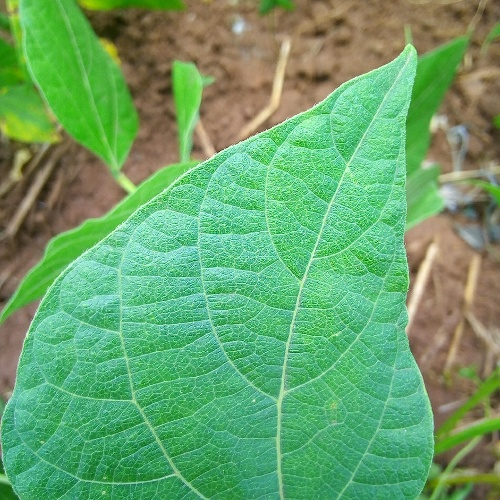

In [31]:
display(Image(local_data_path+'/train/healthy/healthy_train.0.jpg'))

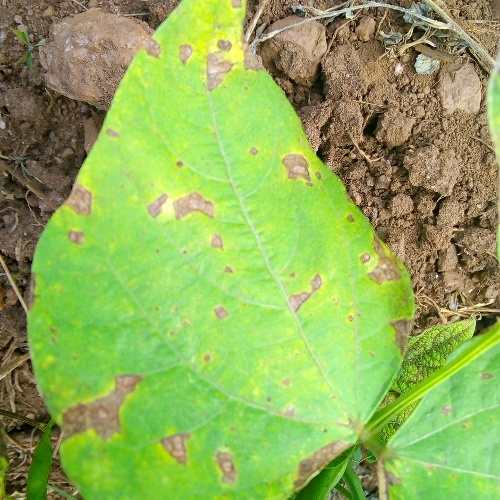

In [32]:
display(Image(local_data_path+'/train/angular_leaf_spot/angular_leaf_spot_train.124.jpg'))

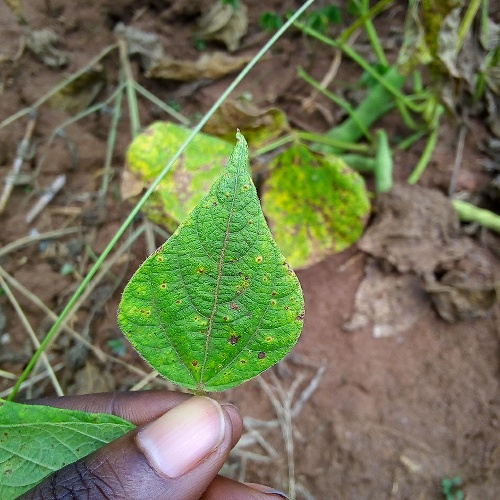

In [33]:
display(Image(local_data_path+'/train/bean_rust/bean_rust_train.162.jpg'))

In [34]:
batch_size = 128
img_height = 224
img_width = 224

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(local_data_path+'/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.


2022-09-19 22:46:05.338456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(local_data_path+'/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(local_data_path+'/validation',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [39]:
classes=train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


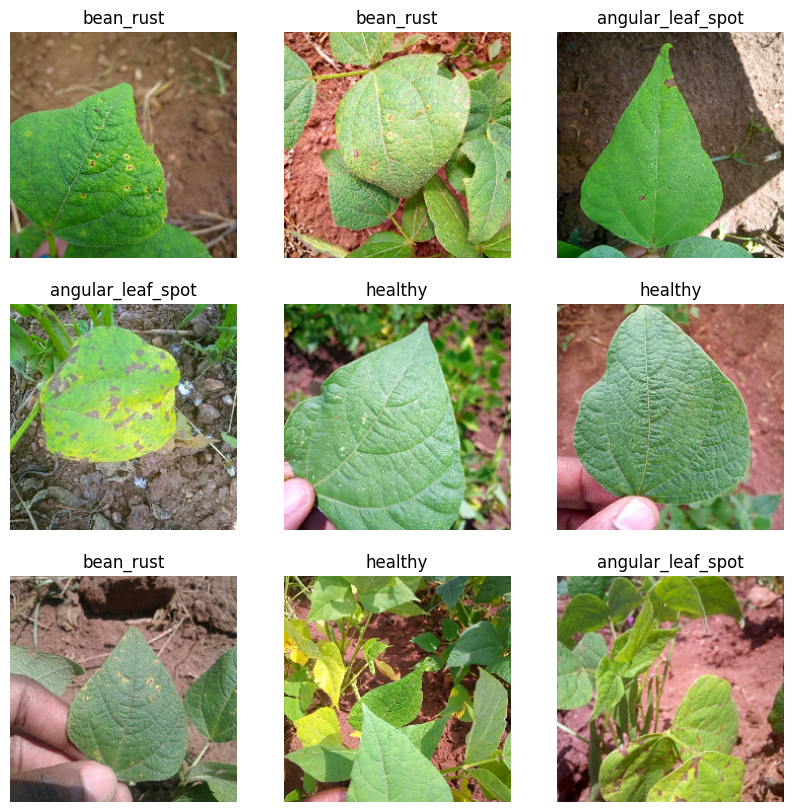

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [43]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [44]:
feature_extractor_layer.trainable = False

In [45]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [46]:
tf.random.set_seed(111)

In [47]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [48]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [49]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 16s 1s/step - loss: 1.2028 - accuracy: 0.4217 - val_loss: 0.7926 - val_accuracy: 0.6466
Epoch 2/20
9/9 [==============================] - 13s 2s/step - loss: 0.8295 - accuracy: 0.6170 - val_loss: 0.5978 - val_accuracy: 0.7519
Epoch 3/20
9/9 [==============================] - 11s 1s/step - loss: 0.6350 - accuracy: 0.7273 - val_loss: 0.5151 - val_accuracy: 0.7895
Epoch 4/20
9/9 [==============================] - 11s 1s/step - loss: 0.5528 - accuracy: 0.7660 - val_loss: 0.4652 - val_accuracy: 0.8045
Epoch 5/20
9/9 [==============================] - 11s 1s/step - loss: 0.5043 - accuracy: 0.7892 - val_loss: 0.4291 - val_accuracy: 0.8120
Epoch 6/20
9/9 [==============================] - 11s 1s/step - loss: 0.4657 - accuracy: 0.7940 - val_loss: 0.4065 - val_accuracy: 0.8271
Epoch 7/20
9/9 [==============================] - 11s 1s/step - loss: 0.4212 - accuracy: 0.8356 - val_loss: 0.3789 - val_accuracy: 0.8421
Epoch 8/20
9/9 [==================

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


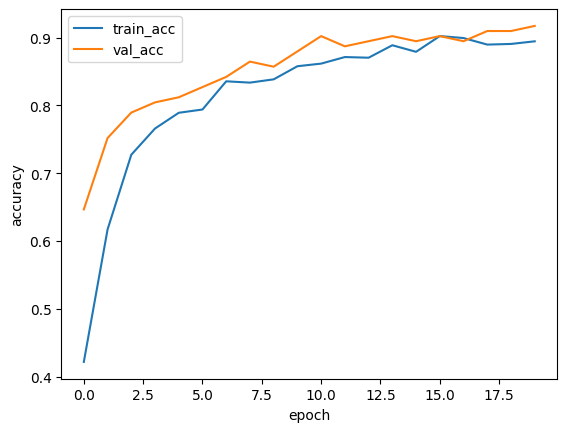

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [54]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

1/1 [==============================] - 1s 1s/step - loss: 0.2743 - accuracy: 0.8828
Test Accuracy: 0.8828125
Test Loss: 0.2742725610733032


1/1 [==============================] - 0s 89ms/step


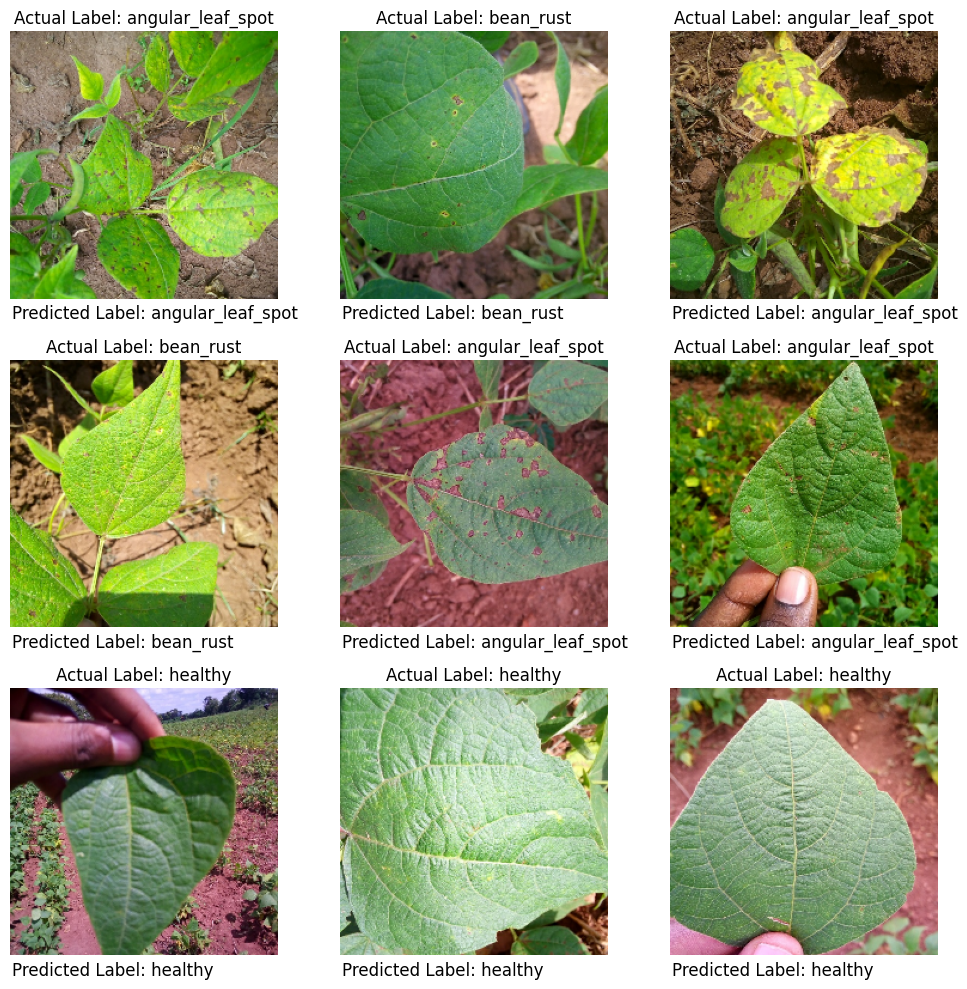

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [56]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [57]:
!ls -alrt models

total 3744
drwxr-xr-x  2 jaganlalthoppe  staff       64 Sep 12 19:41 assets
drwxr-xr-x  6 jaganlalthoppe  staff      192 Sep 19 22:43 ..
drwxr-xr-x  4 jaganlalthoppe  staff      128 Sep 19 22:51 variables
-rw-r--r--  1 jaganlalthoppe  staff  1906386 Sep 19 22:51 saved_model.pb
drwxr-xr-x  6 jaganlalthoppe  staff      192 Sep 19 22:51 .
-rw-r--r--  1 jaganlalthoppe  staff     7425 Sep 19 22:51 keras_metadata.pb


In [58]:
model_loaded = tf.keras.models.load_model('./models/')

In [59]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [60]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [61]:
pred_label=model_loaded.predict(process(local_data_path+'/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

1/1 [==============================] - 1s 564ms/step
healthy


In [62]:
pred_label

array([[2.8087926e-04, 2.9877510e-02, 9.6984160e-01]], dtype=float32)